<a href="https://colab.research.google.com/github/ChepChaf/DH-DL/blob/master/Model_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip3 install talos

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
X, y = pd.read_pickle('X.pkl'), pd.read_pickle('y.pkl')

In [0]:
X.head()

,duration,languages,num_speaker,technology,science,global issues,culture,design,business,entertainment,health,innovation,society,art,social change,future,communication,creativity,biology,humanity,collaboration,environment,economics,medicine,brain,activism,education,community,history,children,TED Fellows,invention,music,health care,politics,cities,psychology,performance,women,nature,...,uncertainty,understands,urge,useless,utterly,vacation,vacuum,variation,vegetables,venture,vessels,vice,vietnam,viral,viruses,visiting,visualize,visually,voting,waited,wash,websites,wedding,whoever,widespread,wikipedia,william,wing,wings,winner,wireless,wires,witnessed,wonders,wore,workplace,worthy,wound,wrapped,zones
0,19.400000,60,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,16.283333,43,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,21.433333,26,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,18.600000,35,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,19.833333,48,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,1,0,1,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
y.head()

0    47227110
1     3200520
2     1636292
3     1697550
4    12005869
Name: views, dtype: int64

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [0]:
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

es = EarlyStopping(min_delta=0.001, patience=5, restore_best_weights=True)
mchkp = ModelCheckpoint('initial-model.h5', save_best_only=False)
rlr = ReduceLROnPlateau()

# Initial model
model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_logarithmic_error', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=250, batch_size=2, validation_split=0.2, callbacks=[es, mchkp, rlr])

Train on 1576 samples, validate on 394 samples
Epoch 1/250
1576/1576 [==============================] - 4s 2ms/step - loss: 79.0528 - mean_absolute_error: 1718979.6275 - val_loss: 53.5491 - val_mean_absolute_error: 1656155.0512
Epoch 2/250
1576/1576 [==============================] - 3s 2ms/step - loss: 40.1407 - mean_absolute_error: 1716641.5208 - val_loss: 37.5299 - val_mean_absolute_error: 1653578.4429
Epoch 3/250
1576/1576 [==============================] - 3s 2ms/step - loss: 28.1484 - mean_absolute_error: 1712103.3964 - val_loss: 28.5383 - val_mean_absolute_error: 1649148.7175
Epoch 4/250
1576/1576 [==============================] - 3s 2ms/step - loss: 21.0591 - mean_absolute_error: 1704768.3085 - val_loss: 22.4622 - val_mean_absolute_error: 1642383.9124
Epoch 5/250
1576/1576 [==============================] - 3s 2ms/step - loss: 16.1248 - mean_absolute_error: 1693461.0541 - val_loss: 17.9109 - val_mean_absolute_error: 1632431.9873
Epoch 6/250
1576/1576 [=========================

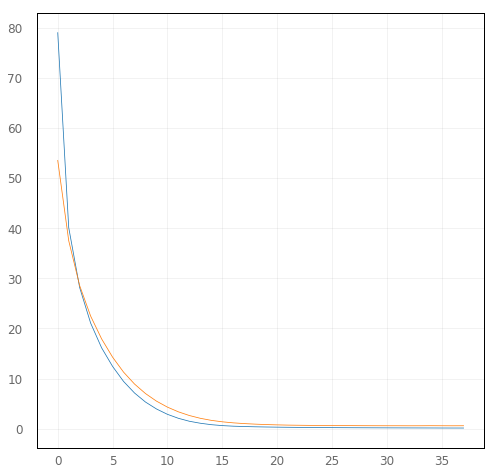

In [0]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(len(history.history['loss'])), history.history['loss'], label='loss')
plt.plot(np.arange(len(history.history['val_loss'])), history.history['val_loss'], label='val_loss')

plt.show()

In [0]:
model.evaluate(X_test, y_test)

348/348 [==============================] - 0s 78us/step


[0.49572519033119594, 1032335.720545977]

In [0]:
predictions = model.predict(X_test)

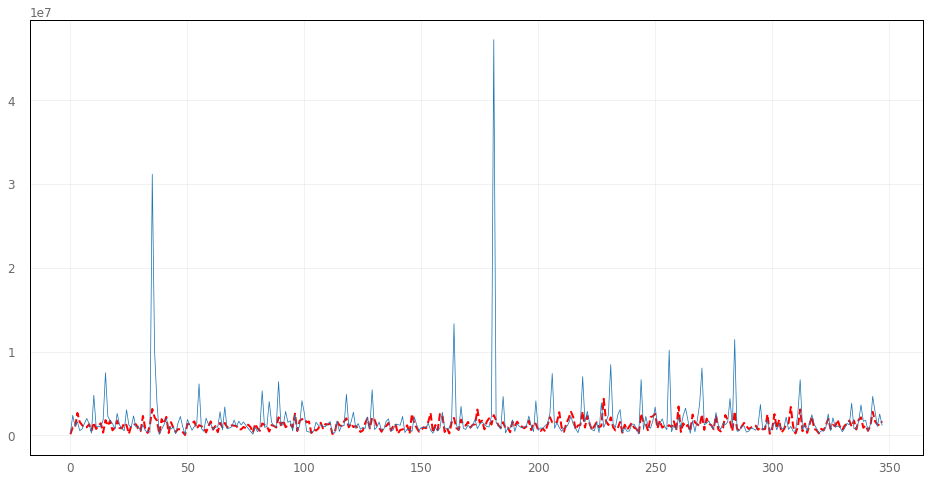

In [0]:
plt.figure(figsize=(16, 8))
plt.plot(np.arange(len(predictions)), predictions, color='r', linestyle='--', linewidth=2.0)
plt.plot(np.arange(len(y_test)), y_test)

In [0]:
df = pd.DataFrame(data={ 'predictions': predictions.flatten(), 'y_test': y_test.values })

In [0]:
df.describe()

,predictions,y_test
count,3.480000e+02,3.480000e+02
mean,1.239278e+06,1.830158e+06
std,6.657819e+05,3.358269e+06
min,4.393723e+04,1.153460e+05
25%,7.908488e+05,7.699342e+05
50%,1.140730e+06,1.133126e+06
75%,1.579278e+06,1.735993e+06
max,4.371315e+06,4.722711e+07


In [0]:
import talos as ta
from talos.utils import hidden_layers, early_stopper

from keras.layers import BatchNormalization

In [0]:
import time

def ted_model(X_train, y_train, X_val, y_val, params):
  rlr = ReduceLROnPlateau()

  timestr = time.strftime("%Y%m%d-%H%M%S")
  
  network = Sequential()
  
  network.add(Dense(params['first_neuron'], input_shape=(X_train.shape[1],), activation='relu'))
  network.add(Dropout(params['dropout']))

  hidden_layers(network, params, 1)
  
  network.add(BatchNormalization())
  network.add(Dense(1))
  
  network.compile(optimizer=params['optimizer'], loss=params['loss'], metrics=['mae', 'mape'])
  
  out = network.fit(
      X_train, y_train,
      epochs=50,
      batch_size=params['batch_size'],
      validation_data=[X_val, y_val],
      callbacks=[rlr]
  )
  
  return out, network

In [0]:
params = {
    'first_neuron': [512, 256],
    'activation': ['relu'],
    'dropout': [0, 0.25],
    'hidden_layers': [3, 4],
    'shapes': ['brick'],
    'optimizer': ['adam'],
    'batch_size': [64, 128],
    'loss': ['mean_squared_error']
}

In [0]:
scan = ta.Scan(
    X_train, y_train.values.reshape(-1, 1), 
    params=params, 
    model=ted_model, 
    experiment_name='7.1', 
    val_split=.2, 
    reduction_metric='val_loss',
    minimize_loss=True,
    clear_session=True
)


















  0%|          | 0/16 [00:00<?, ?it/s]

Train on 1576 samples, validate on 394 samples
Epoch 1/50
1576/1576 [==============================] - 2s 1ms/step - loss: 6949546523840.3242 - mean_absolute_error: 1621617.1529 - mean_absolute_percentage_error: 100.0000 - val_loss: 15919739071784.2852 - val_mean_absolute_error: 2048413.6593 - val_mean_absolute_percentage_error: 100.0023
Epoch 2/50
 448/1576 [=======>......................] - ETA: 0s - loss: 4697642687341.7139 - mean_absolute_error: 1486131.6250 - mean_absolute_percentage_error: 100.0004

In [0]:
ta.Deploy(scan, '7.0', metric='val_loss')

Deploy package 7.0 have been saved.


In [0]:
!cp /content/7.0.zip "/content/drive/My Drive/talos_experiments/7.0.zip"
!cp -r /content/7 "/content/drive/My Drive/talos_experiments/7"

In [0]:
scan.best_model(metric='val_loss').summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               192000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 171)               43947     
_________________________________________________________________
dropout_2 (Dropout)          (None, 171)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 86)                14792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 86)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [0]:
report = ta.Reporting(scan)

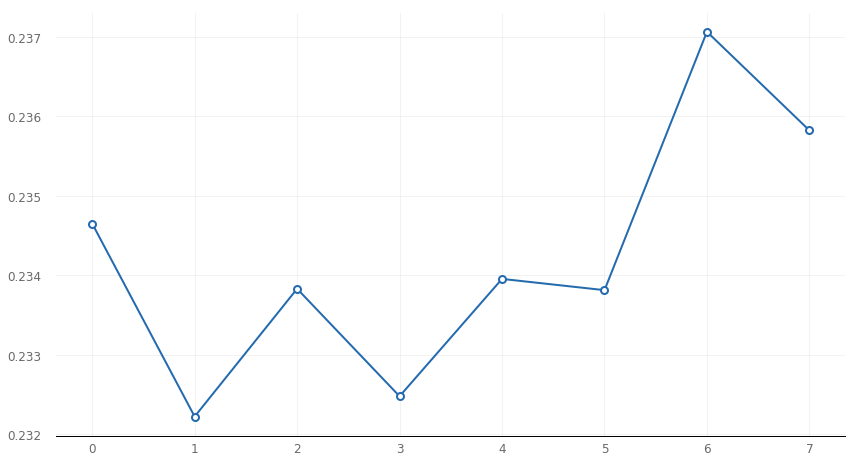

In [0]:
report.plot_line('val_loss')

In [0]:
scan.data.sort_values('val_loss')

,round_epochs,val_loss,val_mean_absolute_error,val_mean_absolute_percentage_error,loss,mean_absolute_error,mean_absolute_percentage_error,lr,activation,batch_size,dropout,first_neuron,hidden_layers,loss,optimizer,shapes,None
1,5,0.232223,0.568138,4.044242,0.222107,0.552713,3.939020,0.001,relu,2,0.00,512,4,logcosh,adam,funnel,1
3,8,0.232479,0.571975,4.088188,0.222674,0.552444,3.936472,0.001,relu,2,0.00,256,4,logcosh,adam,funnel,3
5,6,0.233814,0.575533,4.122150,0.223410,0.553951,3.948712,0.001,relu,2,0.25,512,4,logcosh,adam,funnel,5
2,8,0.233831,0.576112,4.128185,0.221673,0.550398,3.919956,0.001,relu,2,0.00,256,3,logcosh,adam,funnel,2
4,7,0.233955,0.576450,4.131307,0.221971,0.551503,3.928876,0.001,relu,2,0.25,512,3,logcosh,adam,funnel,4
0,8,0.234652,0.578333,4.148345,0.221633,0.550988,3.926240,0.001,relu,2,0.00,512,3,logcosh,adam,funnel,0
7,4,0.235824,0.581229,4.174118,0.225214,0.556889,3.969201,0.001,relu,2,0.25,256,4,logcosh,adam,funnel,7
6,6,0.237066,0.581701,4.176031,0.221762,0.550907,3.923968,0.001,relu,2,0.25,256,3,logcosh,adam,funnel,6


In [0]:
m = scan.best_model('val_loss')

In [0]:
predictions = m.predict(X_test)

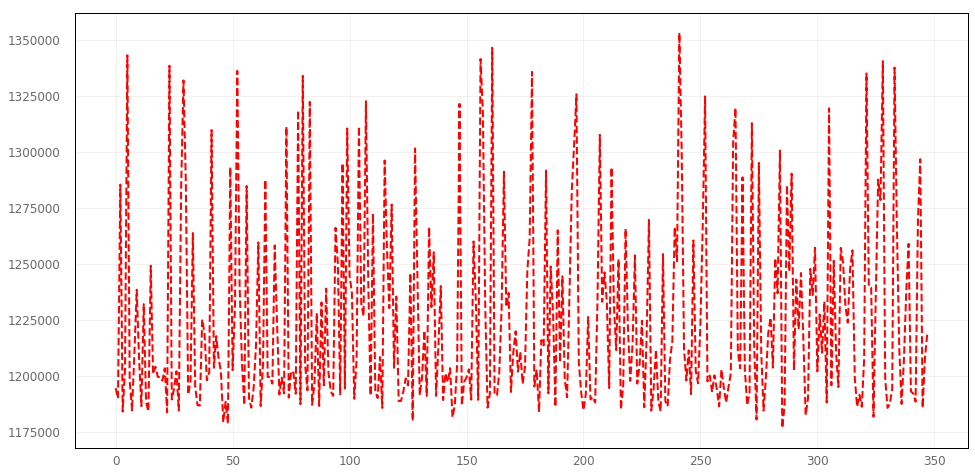

In [0]:
plt.figure(figsize=(16, 8))
plt.plot(np.arange(len(predictions)), np.exp(predictions), color='r', linestyle='--', linewidth=2.0)